# Финальный проект

## Условие задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

### План работы

- Подготовка и анализ данных
- Удаление аномалий в данных
- Создание и обучение моделей
- Проверка модели на адекватность
- Отчёт

## Подготовка  и анализ данных

Импортируем библиотеки

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy.stats import randint
import scipy.stats as stats

import pylab
pd.set_option('display.max_columns', None)

import warnings 
warnings.filterwarnings("ignore") 

In [66]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_error

import xgboost as xgb
from catboost import CatBoostRegressor

Загрузим датасеты

In [3]:
data_arc = pd.read_csv('/home/andrey/Datasets/final/data_arc.csv',  parse_dates=[1,2])
data_bulk = pd.read_csv('/home/andrey/Datasets/final/data_bulk.csv', index_col= 'key')
data_bulk_time = pd.read_csv('/home/andrey/Datasets/final/data_bulk_time.csv', index_col= 'key')
data_gas = pd.read_csv('/home/andrey/Datasets/final/data_gas.csv', index_col= 'key')
data_temp = pd.read_csv('/home/andrey/Datasets/final/data_temp.csv')
data_wire = pd.read_csv('/home/andrey/Datasets/final/data_wire.csv', index_col= 'key')
data_wire_time = pd.read_csv('/home/andrey/Datasets/final/data_wire_time.csv', index_col= 'key')

#### У нас есть следующие файлы с данными:

- `data_arc` — данные об электродах;
- `data_bulk` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time` *—* данные о подаче сыпучих материалов (время);
- `data_gas` — данные о продувке сплава газом;
- `data_temp` — результаты измерения температуры;
- `data_wire` — данные о проволочных материалах (объём);
- `data_wire_time` — данные о проволочных материалах (время).

Посмотрим на размер датасетов

In [4]:
data = [data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time]
for x in data:
    print(x.shape)

(14876, 5)
(3129, 15)
(3129, 15)
(3239, 1)
(15907, 3)
(3081, 9)
(3081, 9)


#### Изучим подробнее датасет с данными о подаче сыпучих материалов `data_bulk` 

In [5]:
data_bulk.head()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [6]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 1 to 3241
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Bulk 1   252 non-null    float64
 1   Bulk 2   22 non-null     float64
 2   Bulk 3   1298 non-null   float64
 3   Bulk 4   1014 non-null   float64
 4   Bulk 5   77 non-null     float64
 5   Bulk 6   576 non-null    float64
 6   Bulk 7   25 non-null     float64
 7   Bulk 8   1 non-null      float64
 8   Bulk 9   19 non-null     float64
 9   Bulk 10  176 non-null    float64
 10  Bulk 11  177 non-null    float64
 11  Bulk 12  2450 non-null   float64
 12  Bulk 13  18 non-null     float64
 13  Bulk 14  2806 non-null   float64
 14  Bulk 15  2248 non-null   float64
dtypes: float64(15)
memory usage: 391.1 KB


Сразу бросается в глаза, что некоторые сыпучие материалы добавляют чаще чем другие, посмотрим сколько % пропущенных значений в различны столбцах датасета `data_bulk`

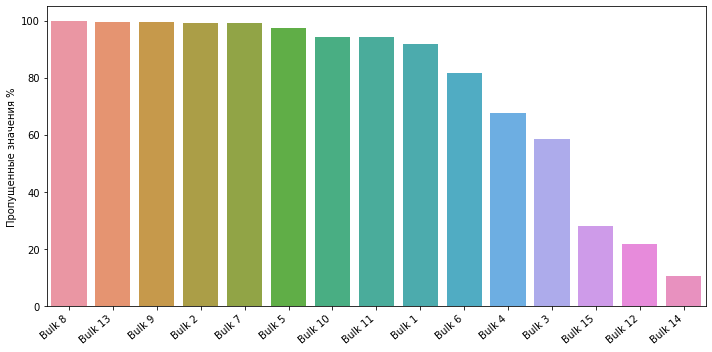

Bulk 8     99.968041
Bulk 13    99.424736
Bulk 9     99.392777
Bulk 2     99.296900
Bulk 7     99.201023
Bulk 5     97.539150
Bulk 10    94.375200
Bulk 11    94.343241
Bulk 1     91.946309
Bulk 6     81.591563
Bulk 4     67.593480
Bulk 3     58.517098
Bulk 15    28.155960
Bulk 12    21.700224
Bulk 14    10.322787
dtype: float64


In [7]:
def missing(df):
    missing_scores = pd.DataFrame(((df.isna().sum())/3129).sort_values(ascending=False)*100
                              , columns=['Пропущенные значения %'])
    missing_scores = missing_scores[(missing_scores.T != 0).any()]
    plt.figure(figsize=(10,5))
    ax =sns.barplot(data = missing_scores,x = missing_scores.index
                , y = 'Пропущенные значения %', orient='v')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.tight_layout()
    plt.show()
    print((df.isna().sum()/3129).sort_values(ascending=False)*100)
missing(data_bulk)

Много сыпучих материалов добавляют достоточно редко (только в 6 процентах случаев и реже)

Удалим столбец bulk 8 т.к. эта добавка практически не используется.

In [8]:
data_bulk = data_bulk.drop(['Bulk 8'], axis = 1)

#### Таким же образом изучим датафрейм `data_wire` 

In [9]:
data_wire.head()

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Wire 1  3055 non-null   object
 1   Wire 2  1079 non-null   object
 2   Wire 3  63 non-null     object
 3   Wire 4  14 non-null     object
 4   Wire 5  1 non-null      object
 5   Wire 6  73 non-null     object
 6   Wire 7  11 non-null     object
 7   Wire 8  19 non-null     object
 8   Wire 9  29 non-null     object
dtypes: object(9)
memory usage: 240.7+ KB


Так же видно, что одни проволочные материалы используются чаще чем другие, посомтрим насколько:

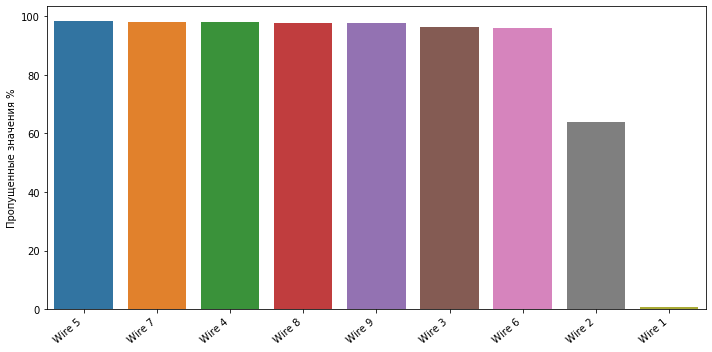

Wire 5    98.434004
Wire 7    98.114414
Wire 4    98.018536
Wire 8    97.858741
Wire 9    97.539150
Wire 3    96.452541
Wire 6    96.132950
Wire 2    63.982103
Wire 1     0.830936
dtype: float64


In [11]:
missing(data_wire)

Аналогично с датафреймом `data_bulk`, есть активно используемые проволочные материалы `Wire 1` и `Wire 2`. Остальные материалы используются крайне редко, только в 2-3% случаев.

Объединим датафреймы `data_bulk`, `data_wire`

In [12]:
data_bw = data_bulk.join(data_wire)

In [13]:
data_bw.head()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Изучим датафрейм `data_arc`

In [14]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [15]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


- Из датафрейма видно, что есть время начала и окончания нагрева, из него можно рассчитать время которое было затрачено на подачу энергии. 

- Так же есть два столбца с активной и реактивной мощностью.

Посмотрим как распределены данные активной и реактивной мощности

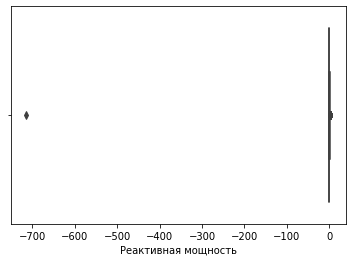

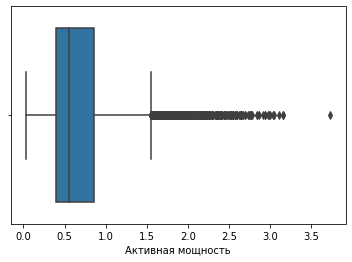

In [16]:
def  boxplotpower():
    #построим boxplot реактивной
    sns.boxplot(data_arc['Реактивная мощность'])
    plt.show()

    #и активной мощности
    sns.boxplot(data_arc['Активная мощность'])
    plt.show()

boxplotpower()

Есть явный выброс в реактивной мощности (значение -700) и выброс в активной мощности(значение более 3.5), сразу избавимся от выбросов и посмотроим график распределения реактивной мощности ещё раз, что бы убедится, что больше выбросов нет.

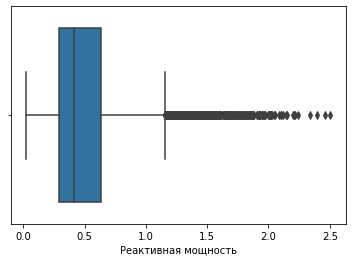

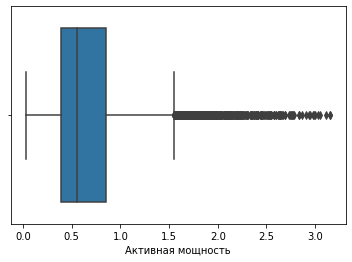

In [17]:
data_arc = data_arc[data_arc['Активная мощность'] < 3.5]
data_arc = data_arc[data_arc['Реактивная мощность'] > 0]
boxplotpower()

С данными всё в порядке, больше явных выбросов нет.

#### Т.к. у нас есть данные по времени замера, мы можем рассчитать потребление в кВт/ч

Формула для расчёта потребления:

$$
kWh = Wt
$$

Где:

- W - мощность
- t - время

Найдём общее время замера в часах

In [18]:
data_arc['Общее время'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']
                          ).dt.seconds.astype(int)/3600

Расчитаем потребление для активной и реактивной мощности.

In [19]:
data_arc['Реактивное потребление'] = data_arc['Общее время']*data_arc['Реактивная мощность']
data_arc['Активное потребление'] = data_arc['Общее время']*data_arc['Активная мощность']

Удалим признаки со временем, они нам больше не понадобятся

In [20]:
data_arc = data_arc.drop(['Начало нагрева дугой', 'Конец нагрева дугой'], axis = 1)

Создадим признаки:
- с общим количеством операций с каждым отдельным сплавом
- с суммарной полной мощностью и потреблением 
- суммарным временем.

In [21]:
operations = []
a_power = []
r_power = []
time = []
a_consumption = []
r_consumption = []


for i in range(1, 3242): #сделаем цикл для создания целевого признака
    operations.append(len(data_arc[data_arc['key'] == i]))
    a_power.append((data_arc[data_arc['key'] == i])['Активная мощность'].sum())
    r_power.append((data_arc[data_arc['key'] == i])['Реактивная мощность'].sum())
    time.append((data_arc[data_arc['key'] == i])['Общее время'].sum())
    a_consumption.append((data_arc[data_arc['key'] == i])['Активное потребление'].sum())
    r_consumption.append((data_arc[data_arc['key'] == i])['Реактивное потребление'].sum())
final_arc = pd.DataFrame(index = range(1, len(operations)+1)) 

In [22]:
final_arc['operations'] = operations
final_arc['a_power'] = a_power
final_arc['r_power'] = r_power
final_arc['time'] = time
final_arc['a_consumption'] = a_consumption
final_arc['r_consumption'] = r_consumption

In [23]:
final_arc.shape

(3241, 6)

#### Изучим датафрейм `data_gas`

In [24]:
data_gas.head()

,Газ 1
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692


In [25]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3239 entries, 1 to 3241
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Газ 1   3239 non-null   float64
dtypes: float64(1)
memory usage: 50.6 KB


- здесь у нас только один признак, это информация о продувке сплава газом

Построим boxplot

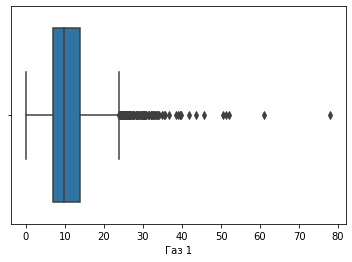

In [26]:
sns.boxplot(data_gas['Газ 1'])
plt.show()

Есть явный выброс в значениях более 70, в дальнейшем удалим его.

Объединим датафреймы `data_bw` и `data_gas`

In [27]:
data_bwg = data_gas.join(data_bw)

In [28]:
data_bwg.shape

(3239, 24)

Проверим на дубликаты

In [29]:
data_bwg.duplicated().sum()

0

#### Изучим датафрейм `data_temp`

In [30]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


Последний экземпляр стали был под номером 3241, он нам понадобится, для взятия последней температуры в образце как целевого признака.

In [31]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


**Есть пропущенные значения в измерениях температуры, скорее всего это произошло из-за неисправности датчика.**

Создадим признак с первым измерением температуры, если замер всего 1 установим значение как nan.

In [32]:
first_temp = []

for i in range(1, 3242): #сделаем цикл для создания целевого признака
    if len(data_temp[data_temp['key'] == i]) < 2: #если по образцу есть  1 замер температуры, заменим его на Nan
        first_temp.append(np.nan)
    else:   #для остальных возьмём первое
        first_temp.append((data_temp[data_temp['key'] == i].head(1)['Температура'].values)[0])

### Выделим целевой признак

Целевым признаком по условиям задачи, является температура образца стали на последнем этапе обработки.

In [33]:
temp = []

for i in range(1, 3242): #сделаем цикл для создания целевого признака
    if len(data_temp[data_temp['key'] == i]) < 2: #если по образцу есть  1 замер температуры, заменим его на Nan
        temp.append(np.nan)
    else:   #для остальных возьмём последнее значение
        temp.append((data_temp[data_temp['key'] == i].tail(1)['Температура'].values)[0])
        
final_temp = pd.DataFrame(temp, columns = ['temp'], index = range(1, len(temp)+1)) 
final_temp['first_temp'] = first_temp

In [34]:
final_temp.shape

(3241, 2)

Посмотрим на распределение целевого признака:

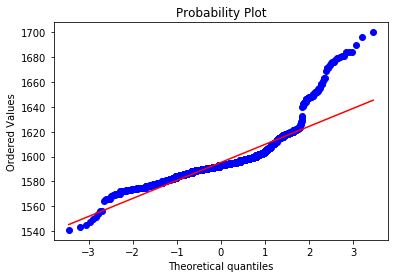

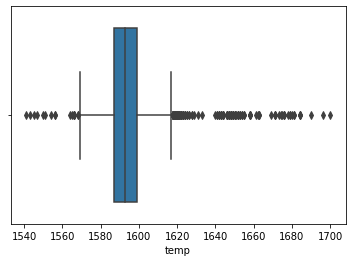

In [35]:
dna = final_temp.dropna()

stats.probplot(dna['temp'], dist="norm", plot=pylab)
pylab.show()

sns.boxplot(final_temp['temp'])
plt.show()

В распределении целевого признака явных выбросов нет, т.к. у нас нет возможности уточнить какие температуры являются ошибочными в процессе обработки стали, что- то удалять из целевого признака не будем.

## Объединение данных

Объединим все полученные датафреймы в один

In [36]:
df = final_temp.join(final_arc).join(data_bwg)

In [37]:
df.head()

,temp,first_temp,operations,a_power,r_power,time,a_consumption,r_consumption,Газ 1,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1,1613.0,1571.0,5,4.878147,3.183241,0.305000,0.335501,0.218863,29.749986,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1602.0,1581.0,4,3.052598,1.998112,0.225278,0.203838,0.135442,12.555561,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1599.0,1596.0,5,2.525882,1.599076,0.181944,0.123218,0.078038,28.554793,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1625.0,1601.0,4,3.209250,2.060298,0.205833,0.186295,0.119427,18.841219,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1602.0,1576.0,4,3.347173,2.252643,0.241389,0.277082,0.184706,5.413692,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
df.shape

(3241, 32)

Избавимся от строк с nan в целевом признаке

In [39]:
df['temp'] = df['temp'].replace(np.nan, 0)
df = df.query('temp != 0')

Как ранее заметили удалим выбросы в стобце gas

In [40]:
df = df[df['Газ 1'] < 70]

Проверим, есть ли сильные выбросы в сыпучих и проволочных материалах.

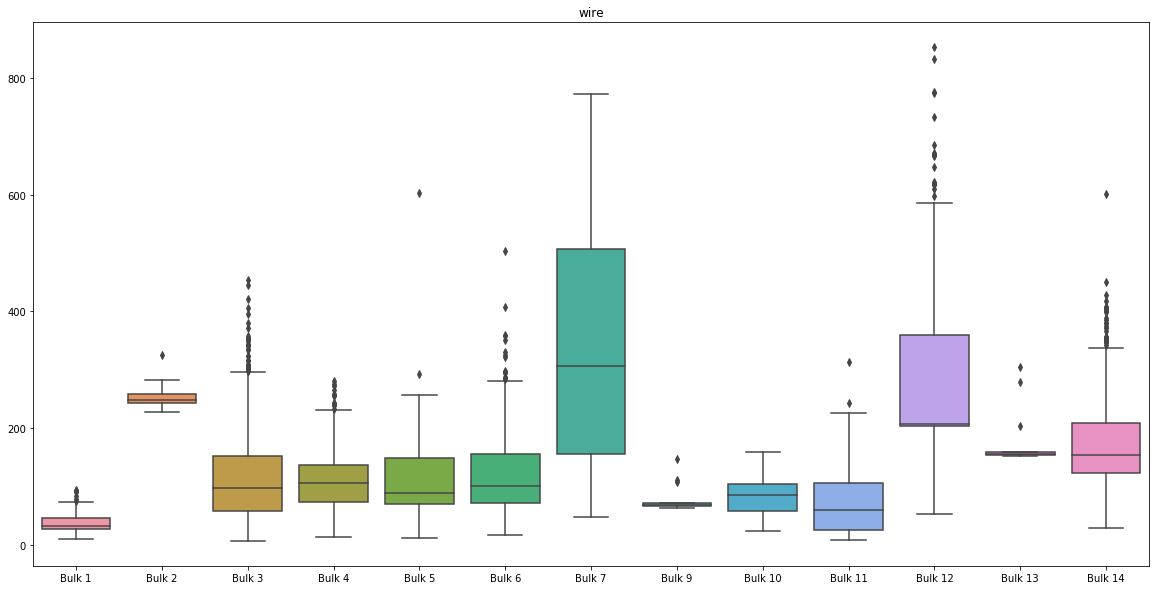

In [41]:
plt.figure(figsize=(20,10))
ax = sns.boxplot(data=df.iloc[:,9:22])
ax.set_title('wire')
plt.show()

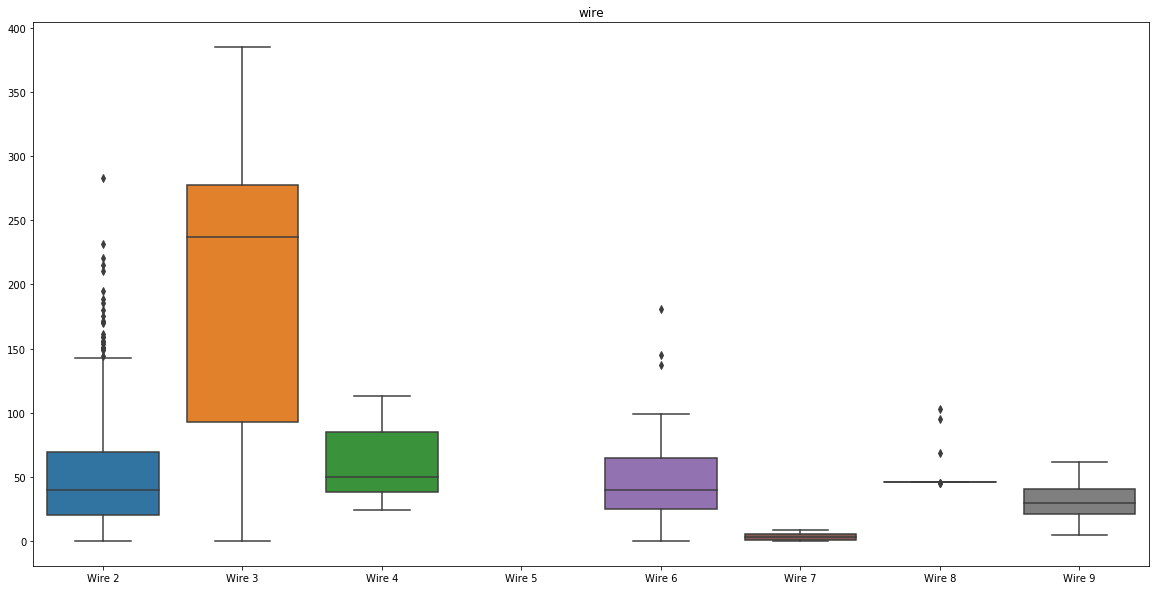

In [42]:
plt.figure(figsize=(20,10))
ax = sns.boxplot(data=df.iloc[:,24:33])
ax.set_title('wire')
plt.show()

Явных выбросов нет, удалим признак `Wire 5`, т.к. в нём остались только nan

In [43]:
df = df.drop(['Wire 5'], axis = 1)

По результатам анализа и подготовки данных можно сказать следующее:

- Некоторые сыпучие и проволочные материалы используются значительно чаще чем другие.
- Удалось выделить изначальную температуру образца стали.
- Получилось создать ряд дополнительных признаков из датасета `data_arc`

## Обучение моделей

Разделим выборку на train и test, кросс валидацию для обучения моделей будем проводить с помощью RandomizedSearchCV

In [44]:
y = df['temp']
X = df.drop(['temp'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=12345)

- Decision Tree

In [45]:
%%time

X_train_tree = X_train.iloc[:,0:10].fillna(0)
X_test_tree = X_test.iloc[:,0:10].fillna(0)

dt_clf = DecisionTreeRegressor()

parameters = { 
              'criterion': ['mse', 'friedman_mse', 'mae'],
              'max_depth': [2, 3, 4, 5, 6, 7, 8],
              'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                                       }


dt_rscv = RandomizedSearchCV(dt_clf, param_distributions = parameters, scoring = "neg_mean_absolute_error",
                             cv = 4, verbose = 1, random_state = 12345, n_jobs = -1, n_iter = 20)



dt = dt_rscv.fit(X_train_tree, y_train)

best_par = dt.best_estimator_.get_params()

preds = dt.predict(X_test_tree)
print("Лучшие гиперпараметры для дерева решений")
print()
print(dt.best_estimator_.get_params())
print("MAE", (mean_absolute_error(y_test, preds)))

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.0s finished


Лучшие гиперпараметры для дерева решений

{'ccp_alpha': 0.0, 'criterion': 'mae', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'best'}
MAE 7.77979797979798
CPU times: user 354 ms, sys: 68.1 ms, total: 423 ms
Wall time: 1.18 s


- XGBoost

In [68]:
%%time
xgb_r = xgb.XGBRegressor()

parameters = { 
              'learning_rate': [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
              'max_depth': randint(2,200),
              'n_estimators': randint(100, 10000),
              'min_child_weight' : randint(1,10),
              'sampling_method' : ['uniform', 'gradient_based'], 
              'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
                                       }


xgb_rscv = RandomizedSearchCV(xgb_r, param_distributions = parameters, scoring = "neg_mean_absolute_error",
                             cv = 3, verbose = 1, random_state = 12345, n_jobs = -1, n_iter = 30)



model_xgboost = xgb_rscv.fit(X_train, y_train)

best_par = model_xgboost.best_estimator_.get_params()

preds = model_xgboost.predict(X_test)
print("Лучшие гиперпараметры XGBoost")
print()
print(model_xgboost.best_estimator_.get_params())
print("MAE", (mean_absolute_error(y_test, preds)))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   36.9s finished


Лучшие гиперпараметры XGBoost

{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 124, 'min_child_weight': 4, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 9632, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0.1, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'sampling_method': 'gradient_based'}
MAE 6.1514858053188135
CPU times: user 38.9 s, sys: 302 ms, total: 39.2 s
Wall time: 40.2 s


- CatBoost

In [58]:
%%time
cb = CatBoostRegressor()

parameters = { 
              'learning_rate': [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
              'max_depth': randint(2,30),
              'n_estimators': randint(100, 500),
              'loss_function': ['MAE'],
              'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS'],
                                       }


cb_rscv = RandomizedSearchCV(cb, param_distributions = parameters, scoring = "neg_mean_absolute_error",
                             cv = 3, verbose = 0, random_state = 12345, n_jobs = -1, n_iter = 20)



model_cb = cb_rscv.fit(X_train, y_train)

best_par = model_cb.best_estimator_.get_params()

preds = model_cb.predict(X_test)
print("Лучшие гиперпараметры CatBoost")
print()
print(model_cb.best_estimator_.get_params())
print("MAE", (mean_absolute_error(y_test, preds)))

0:	learn: 9.4900344	total: 1.11ms	remaining: 242ms
1:	learn: 9.2008893	total: 2.1ms	remaining: 227ms
2:	learn: 8.9538119	total: 3.49ms	remaining: 250ms
3:	learn: 8.6919137	total: 4.33ms	remaining: 232ms
4:	learn: 8.5113623	total: 5.39ms	remaining: 230ms
5:	learn: 8.4090522	total: 6.22ms	remaining: 220ms
6:	learn: 8.2784062	total: 7.55ms	remaining: 228ms
7:	learn: 8.1353441	total: 8.73ms	remaining: 229ms
8:	learn: 8.1032073	total: 9.34ms	remaining: 217ms
9:	learn: 8.0107628	total: 10.6ms	remaining: 221ms
10:	learn: 7.9179225	total: 12.1ms	remaining: 228ms
11:	learn: 7.8259968	total: 12.9ms	remaining: 221ms
12:	learn: 7.7725114	total: 13.8ms	remaining: 218ms
13:	learn: 7.7143959	total: 14.4ms	remaining: 209ms
14:	learn: 7.5865825	total: 15.1ms	remaining: 205ms
15:	learn: 7.5229914	total: 15.7ms	remaining: 198ms
16:	learn: 7.4932161	total: 16.3ms	remaining: 193ms
17:	learn: 7.4534538	total: 16.9ms	remaining: 188ms
18:	learn: 7.4164211	total: 17.7ms	remaining: 185ms
19:	learn: 7.3964014	to

Лучший MAE на тестовой выборке у модели XGBoost 6.151

## Проверка модели на адекватность.

Проверим модель на адекватность с помощью DummyRegressor

In [48]:
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)
predict_dummy = dummy.predict(y_test)
mae_dummy = mean_absolute_error(y_test, predict_dummy)
print('MAE на cлучайной выборке:' ,mae_dummy)

MAE на cлучайной выборке: 10.266411203588719


Все модели прошли проверку на адекватность.

## Отчёт

Заказчиком была поставлена задача предсказания температуры стали на производстве.

Целевым признаком является столбец `temp` в датасете `data_temp`

Ключевой метрикой является MAE с целевым значением менее 8.7

В ходе выполнения работы все пункты изначального плана были выполнены, а именно:
- Подготовка и анализ данных
- Удаление аномалий в данных
- Создание и обучение моделей
- Проверка модели на адекватность
- Отчёт

В ходе выполнения работы были следующие трудности:

- Целевой признак был смешан с остальными(промежуточными замерами температуры)
    - решение проблемы: выделение последнего замера температуры в каждом образце.
- Часть данных имела явные аномалии.
    - решение проблемы: построеные графиков boxplot, определение аномалий и их удаление.
    
Ключевыми шагами в решении задачи можно назвать:

- Изучение каждого датафрема по отдельности, анализ данных, генерация фичей.
- Удаление аномалий из данных
- Выделение целевого признака.
- Объединение данных в единый датасет.
- Подготовка и обучения моделей.

Лучшей оказалась модель градиентного бустинга XGBoost, обучение происходило с подбором гиперпараметров randomizedsearchsv и кросс валидацией на 3 фолдах.

Качество модели по метрике **MAE** на тестовоей выборке составило **6.151**

